# Import Dependencies

In [1]:
import os
import copy
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import time
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
torch.serialization.add_safe_globals([CrossEntropyLoss])
torch.serialization.add_safe_globals([set])
%matplotlib inline

!pip3 install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-2-dog-identification/data')

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("cuda")
print(device)

cuda


# Load Data

In [3]:
data_dir = "./2024-fall-ml-3-hw-2-dog-identification" # Path to data directory
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train/train'))) == len(labels))

In [4]:
len(os.listdir(os.path.join(data_dir, 'train/train')))

8000

In [5]:
class_labels = labels.sort_values(by = 'breed', ascending = True)
class_labels = class_labels.breed.unique()
class_labels = class_labels.tolist()

In [6]:
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [7]:
X = labels.id
y = labels.breed

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.4, random_state=SEED, stratify=y) #60% train, stratified by label
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid) #20% test, 20% validation - stratified by label

In [8]:
class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)

        if self.labels is not None:
            label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)

        if self.labels is not None:    
            return np.array(image), label
        
        if self.labels is None:
            return np.array(image)

In [9]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

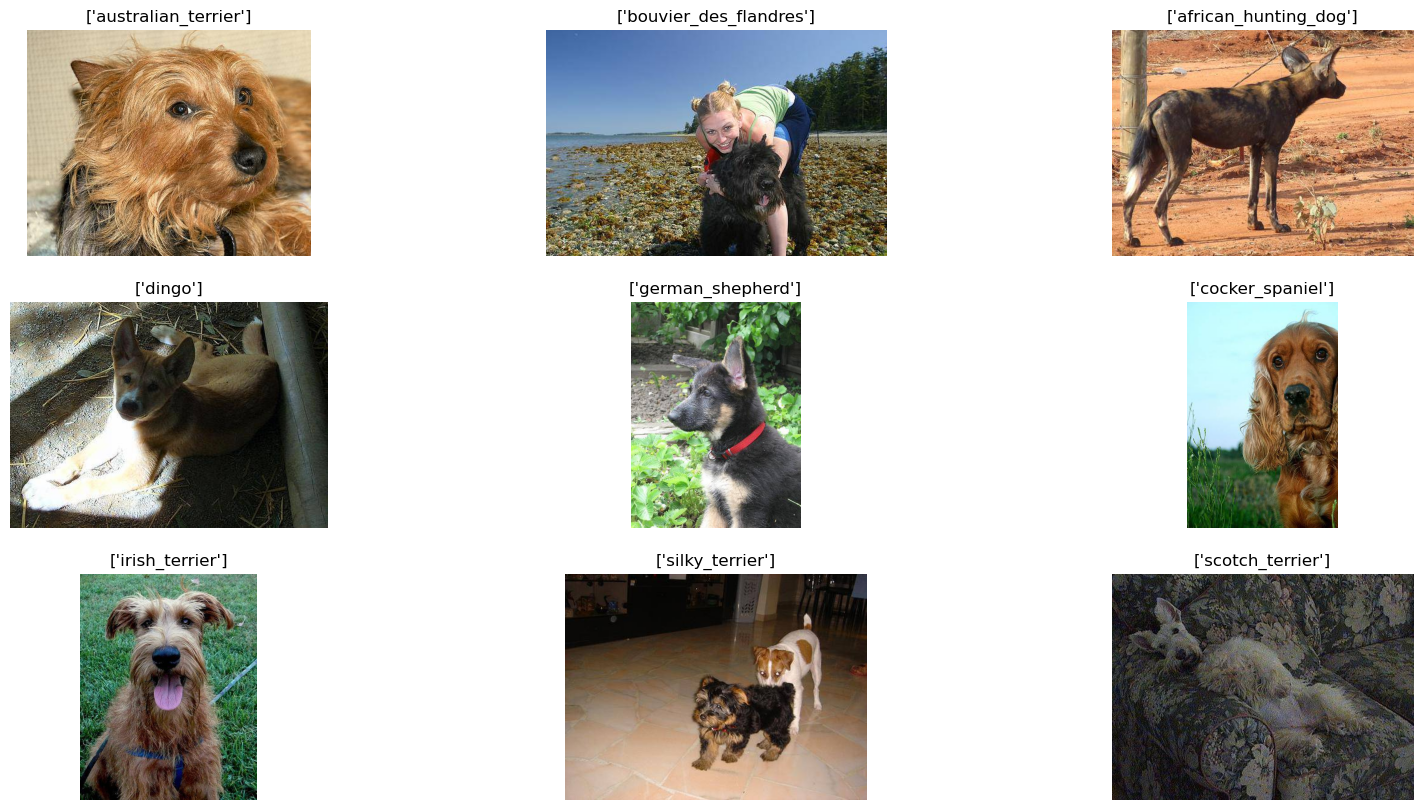

In [10]:
# Transform and Plot Sample Test Images
N_IMAGES = 9

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((286, 286)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_train, labels=y_train, transforms=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_test, labels=y_test, transforms=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
valid_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_valid, labels=y_valid, transforms=transform)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

sample_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_test, labels=y_test)
images = [(image, label) for image, label in [sample_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

# Create Model
#### Design and instantiate a neural network architecture suitable for the classification task at hand. -- transfer learning

In [16]:
def copy_and_crop(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

def copy_and_crop2(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta //2
    return tensor[:, :, delta:tensor_size-delta-1, delta:tensor_size-delta-1] #rounding error for input image size 286 for one of the croppings

class UNet(nn.Module):
    def __init__(self): #,num_classes=120
        super(UNet, self).__init__()

        #self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0) #conv 3x3, 0 padding
        self.aciv1 = nn.ReLU(inplace=True) #ReLu
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.activ2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #max pool 2x2

        # Second convolutional layer
        self.conv12 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.aciv12 = nn.ReLU(inplace=True)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.activ22 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional layer
        self.conv13 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.aciv13 = nn.ReLU(inplace=True)
        self.conv23 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.activ23 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth convolutional layer
        self.conv14 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.aciv14 = nn.ReLU(inplace=True)
        self.conv24 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.activ24 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fifth convolutional layer
        self.conv15 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=0)
        self.aciv15 = nn.ReLU(inplace=True)
        self.conv25 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=0)
        self.activ25 = nn.ReLU(inplace=True)

        # First expansion layer
        self.up_trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) #up-conv 2x2
        #concatenation
        self.conv16 = nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=0)
        self.activ16 = nn.ReLU(inplace=True)
        self.conv26 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0)
        self.activ26 = nn.ReLU(inplace=True)

        # Second expansion layer
        self.up_trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) #up-conv 2x2
        #concatenation
        self.conv17 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=0)
        self.activ17 = nn.ReLU(inplace=True)
        self.conv27 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0)
        self.activ27 = nn.ReLU(inplace=True)

        # Third expansion layer
        self.up_trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) #up-conv 2x2
        #concatenation
        self.conv18 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0)
        self.activ18 = nn.ReLU(inplace=True)
        self.conv28 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.activ28 = nn.ReLU(inplace=True)

        # Fourth expansion layer
        self.up_trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) #up-conv 2x2
        #concatenation
        self.conv19 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.activ19 = nn.ReLU(inplace=True)
        self.conv29 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.activ29 = nn.ReLU(inplace=True)

        #Conv 1x1 layer
        self.out = nn.Conv2d(64, 120, kernel_size=1)

        # Add softmax on output layer
        #self.softmax = F.softmax


    def forward(self, image):
        #encoder
        x1 = self.conv1(image)
        #print(x1.size())
        x2 = self.aciv1(x1)
        x3 = self.conv2(x2)
        #print(x3.size())
        x4 = self.activ2(x3)
        x5 = self.pool1(x4)
        #print(x5.size())
        
        x6 = self.conv12(x5)
        #print(x6.size())
        x7 = self.aciv12(x6)
        x8 = self.conv22(x7)
        #print(x8.size())
        x9 = self.activ22(x8)
        x10 = self.pool2(x9)
        #print(x10.size())

        x11 = self.conv13(x10)
        #print(x11.size())
        x12 = self.aciv13(x11)
        x13 = self.conv23(x12)
        #print(x13.size())
        x14 = self.activ23(x13)
        x15 = self.pool3(x14)
        #print(x15.size())

        x16 = self.conv14(x15)
        #print(x16.size())
        x17 = self.aciv14(x16)
        x18 = self.conv24(x17)
        #print(x18.size())
        x19 = self.activ24(x18)
        x20 = self.pool4(x19)
        #print(x20.size())

        x21 = self.conv15(x20)
        #print(x21.size())
        x22 = self.aciv15(x21)
        x23 = self.conv25(x22)
        #print(x23.size())
        x24 = self.activ25(x23)

        #decoder
        x = self.up_trans1(x24)
        #print(x.size()) 
        y = copy_and_crop(x19, x)
        x = self.conv16(torch.cat([x, y], 1))
        #print(x.size()) 
        x = self.activ16(x)
        x = self.conv26(x)
        x = self.activ26(x)
        #print(x.size()) 

        x = self.up_trans2(x)
       # print(x.size()) 
        y = copy_and_crop(x14, x)
        x = self.conv17(torch.cat([x, y], 1))
        #print(x.size()) 
        x = self.activ17(x)
        x = self.conv27(x)
        x = self.activ27(x)
        #print(x.size())

        x = self.up_trans3(x)
        #print(x.size()) 
        y = copy_and_crop2(x9, x)
        x = self.conv18(torch.cat([x, y], 1))
        #print(x.size()) 
        x = self.activ18(x)
        x = self.conv28(x)
        x = self.activ28(x)
        #print(x.size()) 

        x = self.up_trans4(x)
        #print(x.size()) 
        y = copy_and_crop(x4, x)
        x = self.conv19(torch.cat([x, y], 1))
        #print(x.size()) 
        x = self.activ19(x)
        x = self.conv29(x)
        x = self.activ29(x)
        #print(x.size()) 

        x = self.out(x)
        #print(x.size()) 

        x = torch.flatten(x, 1)
        #print(x.size())
        return x


def test():
    net = UNet()
    x = torch.randn(32,3,286,286)
    y = net(x).to(device)
    print(y.shape)

test()

torch.Size([32, 1200000])


# Training and Validation
#### Implement effective training loops, validation checks, and possibly other regularization techniques to achieve optimal model performance.

In [12]:
plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), 'outputs/best_model.tar')

In [13]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save(model.state_dict(), 'outputs/final_model.tar')

In [14]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [15]:
torch.optim.lr_scheduler

# learning_parameters 
lr = 0.1

# epochs
epochs = 45

# model
model = UNet()
model.to(device)

# parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.1, eps=1e-08)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

# initialize SaveBestModel class
save_best_model = SaveBestModel()

NameError: name 'ResNet50' is not defined

In [ ]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    scheduler.step() #include loss as parameter with plateau
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    #print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    #print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    #print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, criterion
    )
    #print('-'*50)
    
# save the trained model weights for a final time
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

# Submission CSV

In [20]:
# Load model
model = ResNet50(bottleneck_block)
model.load_state_dict(torch.load("outputs/best_model.tar", weights_only=True))
#model.to(device)

<All keys matched successfully>

In [21]:
def get_filenames_without_extensions(directory):
    """Gets a list of filenames without extensions in the given directory."""

    filenames = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            base, ext = os.path.splitext(filename)
            filenames.append(base)
    return filenames

In [22]:
ids = get_filenames_without_extensions(os.path.join(data_dir, 'test/test')) #get all file names in test folder
submission_names = pd.DataFrame({'id' : ids})
submission_names = submission_names.id

In [23]:
sub_data = Dataset_Interpreter(data_path=data_dir+'/test/test/', file_names=submission_names, transforms=transform)
sub_loader = DataLoader(sub_data, batch_size=32, shuffle=False)

In [24]:
all_probabilities = []
with torch.no_grad():
    for batch in sub_loader:
        #inputs = batch['input']  # Adjust according to your dataset
        outputs = model(batch)
        probabilities = torch.softmax(outputs, dim=1)
        all_probabilities.append(probabilities.cpu().numpy())

# Concatenate probabilities from all batches
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Create a DataFrame
df = pd.DataFrame(all_probabilities, columns=class_labels)
df.insert(0, 'id', ids)

# Save to CSV
df.to_csv('outputs/my_submission_resnet.csv', index=False)